In [1]:
from pathlib import Path
print(Path("./data"))

data


In [3]:
from utils import download_data
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data\pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


WindowsPath('data/pizza_steak_sushi')

In [4]:
# create image of size(from ViT paper) 224
IMG_SIZE=224

from torchvision import transforms
transformed=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
print(transformed)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [5]:
from data_setup import create_dataloaders
BATCH_SIZE=32
train_dataloader,test_dataloader,class_names=create_dataloaders(
    train_dir=image_path/"train",
    test_dir=image_path/"test",
    transform=transformed,
    batch_size=BATCH_SIZE,
)

In [6]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x248a9be5960>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

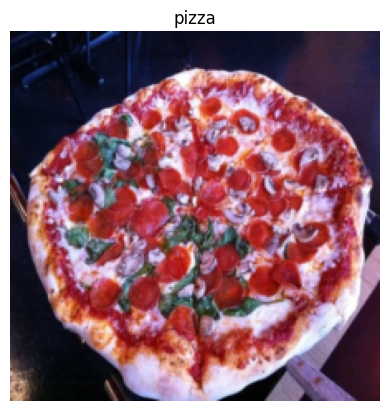

In [8]:
import matplotlib.pyplot as plt
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);